# Introduction

This notebook builds on the results from the notebook titled "Task 1.3. Model". The main components of this notebook are:

- In the preprocessing step, instead of target encoding `make` and `model`, we one hot encode them.
- Hyperparameter tuning for the most promising models, which will be used in the ensemble.
- Model explainability for the most promising model. In this, we aim to explain the output of the model and the features that contribute to this output.

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from preprocess import PreprocessedDataFrame
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

pd.set_option("display.max_rows", None, "display.max_columns", None)

In [ ]:
FOLDER = ''
X = pd.read_csv(FOLDER + 'train.csv')
y= X.pop('price')
print('Total data size:', X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
print('Train:', X_train.shape)
print('Test:', X_test.shape)

X_train.head(1)

Total data size: (16784, 29)
Train: (13427, 29)
Test: (3357, 29)


,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,transmission,curb_weight,power,fuel_type,engine_cap,no_of_owners,depreciation,coe,road_tax,dereg_value,mileage,omv,arf,opc_scheme,lifespan,eco_category,features,accessories,indicative_price
15946,1000462,Porsche Cayenne Hybrid S 3.0A,porsche,cayenne,10,2012.0,NaN,22-oct-2012,suv,"parf car, direct owner sale, hybrid cars",auto,2315.0,245.0,petrol-electric,2995.0,4.0,67590.0,82289.0,2380.0,43327.0,125000.0,102465.0,61479.0,NaN,NaN,uncategorized,3.0l v6 supercharged/hybrid engine with 328bhp...,low mileage! 2 keys! keyless entry/start. bi-x...,NaN


## Preprocessing

### Train data

In [ ]:
preprocessed_df = PreprocessedDataFrame(X_train, y_train, target_encoding=False) # set target_encoding False to get one-hot encoding for make and model

Date: ['reg_date', 'manufactured', 'lifespan', 'original_reg_date']
Num: ['coe', 'curb_weight', 'dereg_value', 'engine_cap', 'omv', 'power', 'road_tax', 'no_of_owners', 'indicative_price', 'mileage', 'depreciation', 'arf']
OneHot Cat: ['title', 'make', 'model']
Label Cat: ['features', 'fuel_type', 'accessories', 'listing_id', 'transmission', 'eco_category', 'opc_scheme', 'category', 'description']



In [ ]:
X_train_prepared = preprocessed_df.build_dataframe()

Input shape: (13427, 29)
Transformed shape: (13427, 776)


**NOTE**: We will drop all the `model` columns, since the number of models is very large and it causes the overall model performance to degrade.

In [ ]:
X_train_prepared = X_train_prepared.drop(X_train_prepared.filter(regex='model_*', axis=1).head().columns, axis=1)

In [ ]:
imputer = SimpleImputer()
X_train_prepared = imputer.fit_transform(X_train_prepared)

### Test data

In [ ]:
X_test_prepared = preprocessed_df.transform_dataframe(X_test)
X_test_prepared = X_test_prepared.drop(X_test_prepared.filter(regex='model_*', axis=1).head().columns, axis=1)
X_test_prepared = imputer.transform(X_test_prepared)

Input shape: (3357, 29)
Transformed shape: (3357, 776)


## Model

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [ ]:
def rmse(model, data, labels):
    predictions = model.predict(data)
    mse = mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse)
    print(rmse)
    
def display_scores(scores):
    print("Scores:", scores)
    print(f"Mean: \033[1m{scores.mean()}\033[0m", )
    print("Standard deviation:", scores.std())
    print()
    
def cvs(model, data, labels):
    scores = cross_val_score(model, data, labels, scoring="neg_mean_squared_error", cv=10)
    rmse_scores = np.sqrt(-scores)
    return rmse_scores

lin_reg 41791.3575886345 6897.225853830483
tree_reg 32200.53447121378 5507.653661486692
forest_reg 24690.15244071518 6752.402208296798
svm_reg 132517.5248220396 15684.439123567485
mlp_reg 90527.18506579146 16228.019611151147
xgb_reg 24481.724177501663 5940.097511480291
light_reg 23821.20009300356 7702.174797941116
cat_reg 21438.07326146705 8028.279040225138


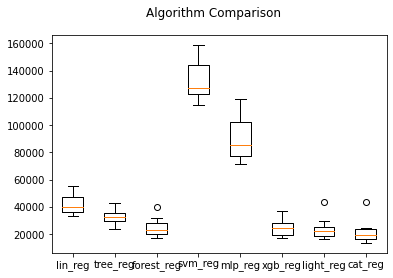

In [ ]:
models = []
models.append(('lin_reg', LinearRegression()))
models.append(('tree_reg', DecisionTreeRegressor(random_state=42)))
models.append(('forest_reg', RandomForestRegressor(n_estimators=30, random_state=42)))
models.append(('svm_reg', SVR()))
models.append(('mlp_reg', MLPRegressor()))
models.append(('xgb_reg', XGBRegressor()))
models.append(('light_reg', LGBMRegressor()))
models.append(('cat_reg', CatBoostRegressor(silent=True)))

results = []
names = []
for name, model in models:
    reg = model.fit(X_train_prepared, y_train)
    scores = cvs(reg, X_train_prepared, y_train)
    # display_scores(rmse_scores)
    results.append(scores)
    names.append(name)
    print(f'{name} \033[1m{scores.mean()}\033[0m {scores.std()}')
    
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

We will pick the most promising classifiers, and try to find the best parameters for each of them. From the above results, it's clear that the best classifiers are:

- RandomForest Regression
- XGBRegressor
- LightGBMRegressor
- CatRegressor

### Hyperparam tuning using Optuna

#### XGBoostRegressor

In [ ]:
import joblib
import optuna 
from optuna import Trial, visualization

from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from optuna import create_study
from optuna.samplers import TPESampler
from optuna.integration import XGBoostPruningCallback, LightGBMPruningCallback

In [ ]:
def xgb_objective(
    trial,
    X,
    y,
    random_state=22,
    n_splits=3,
    n_repeats=2,
    n_jobs=-1,
    early_stopping_rounds=50,
):
    # XGBoost parameters
    params = {
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int('n_estimators', 1000, 5000),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
        "subsample": trial.suggest_loguniform("subsample", 0.4, 0.8),
        "alpha": trial.suggest_loguniform("alpha", 0.01, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "gamma": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 10, 1000),
        "seed": random_state,
        "n_jobs": n_jobs,
    }

    model = XGBRegressor(**params)
    pruning_callback = XGBoostPruningCallback(trial, "validation_0-rmse")
    rkf = RepeatedKFold(
        n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
    )
    X_values = X
    y_values = y
    y_pred = np.zeros_like(y_values)
    for train_index, test_index in rkf.split(X_values):
        X_A, X_B = X_values[train_index, :], X_values[test_index, :]
        y_A, y_B = y_values[train_index], y_values[test_index]
        model.fit(
            X_A,
            y_A,
            eval_set=[(X_B, y_B)],
            eval_metric="rmse",
            verbose=0,
            callbacks=[pruning_callback],
            early_stopping_rounds=early_stopping_rounds,
        )
        y_pred[test_index] += model.predict(X_B)
    y_pred /= n_repeats
    return np.sqrt(mean_squared_error(y_train, y_pred))


In [ ]:
# NOTE: This cell takes about ~8 minutes to run
study = optuna.create_study(direction='minimize',sampler=TPESampler(seed=42))
study.optimize(lambda trial : xgb_objective(trial, X_train_prepared.toarray(), y_train.values), n_trials=20)

[I 2021-11-12 12:22:35,372] A new study created in memory with name: no-name-ef58d47e-14d4-41c7-bb30-65e0b4ba4082
[I 2021-11-12 12:23:45,601] Trial 0 finished with value: 68648.89119469072 and parameters: {'n_estimators': 2498, 'max_depth': 12, 'learning_rate': 0.026975154833351143, 'colsample_bytree': 0.3860670017258661, 'subsample': 0.44568321877181083, 'alpha': 0.029375384576328288, 'lambda': 3.3323645788192616e-08, 'min_child_weight': 539.948440978743}. Best is trial 0 with value: 68648.89119469072.
[I 2021-11-12 12:29:46,996] Trial 1 finished with value: 25463.431617420603 and parameters: {'n_estimators': 3405, 'max_depth': 10, 'learning_rate': 0.005242693862597309, 'colsample_bytree': 0.5804898110927721, 'subsample': 0.7122790911480783, 'alpha': 0.04335281794951567, 'lambda': 4.329370014459266e-07, 'min_child_weight': 23.270677083837796}. Best is trial 1 with value: 25463.431617420603.
[I 2021-11-12 12:32:03,349] Trial 2 finished with value: 31523.03881560184 and parameters: {'n_

In [ ]:
study.best_trial.params

In [ ]:
xgb_best_params = {'n_estimators': 4515, 
               'max_depth': 10, 
               'learning_rate': 0.02189905264076845, 
               'colsample_bytree': 0.20398582452881756, 
               'subsample': 0.6746494931423485, 
               'alpha': 0.18106492819272793, 
               'lambda': 4.3444691085504115, 
               'min_child_weight': 10.525161528906533
              }

In [ ]:
best_xgb_model = XGBRegressor(random_state=42, **xgb_best_params)

In [ ]:
best_xgb_model.fit(X_train_prepared, y_train)

XGBRegressor(alpha=0.18106492819272793, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.20398582452881756, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', lambda=4.3444691085504115,
             learning_rate=0.02189905264076845, max_delta_step=0, max_depth=10,
             min_child_weight=10.525161528906533, missing=nan,
             monotone_constraints='()', n_estimators=4515, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0.181064934, reg_lambda=4.34446907, scale_pos_weight=1,
             subsample=0.6746494931423485, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [ ]:
# Run this cell incase you want to skip the optuna hyperparameter tuning step.
# best_xgb_model = joblib.load('./model_weights/best_xgboost_regressor_optuna.pkl')

In [ ]:
rmse(best_xgb_model, X_test_prepared, y_test)

106282.96130003412


In [ ]:
import joblib
joblib.dump(best_xgb_model, './model_weights/best_xgboost_regressor_optuna.pkl')

['./model_weights/best_xgboost_regressor_optuna.pkl']

### LightGBM

In [ ]:
def lgb_objective(
    trial,
    X,
    y,
    random_state=22,
    n_splits=3,
    n_repeats=2,
    n_jobs=-1,
    early_stopping_rounds=50,
):
    # LightGBM parameters
    params = {
        "verbosity": -1,  # 0 (silent) - 3 (debug)
        "objective": "regression",
        "n_estimators": trial.suggest_int("n_estimators", 1000, 10000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 25),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
        "seed": random_state,
        "n_jobs": n_jobs,
    }

    model = LGBMRegressor(**params)
    pruning_callback = LightGBMPruningCallback(trial, "rmse")
    rkf = RepeatedKFold(
        n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
    )
    X_values = X
    y_values = y
    y_pred = np.zeros_like(y_values)
    for train_index, test_index in rkf.split(X_values):
        X_A, X_B = X_values[train_index, :], X_values[test_index, :]
        y_A, y_B = y_values[train_index], y_values[test_index]
        model.fit(
            X_A,
            y_A,
            eval_set=[(X_B, y_B)],
            eval_metric="rmse",
            verbose=0,
            callbacks=[pruning_callback],
            early_stopping_rounds=early_stopping_rounds,
        )
        y_pred[test_index] += model.predict(X_B)
    y_pred /= n_repeats
    return np.sqrt(mean_squared_error(y_train, y_pred))


In [ ]:
# NOTE: This cell takes about ~8 minutes to run
lgb_study = optuna.create_study(direction='minimize',sampler=TPESampler(seed=42))
lgb_study.optimize(lambda trial : lgb_objective(trial, X_train_prepared.toarray(), y_train.values), n_trials=20)

[I 2021-11-12 13:11:06,112] A new study created in memory with name: no-name-35dea6e9-20a6-4a53-9311-37587efd9679


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=9.016725176148132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.016725176148132
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subs

[I 2021-11-12 13:11:13,679] Trial 0 finished with value: 83624.11685982461 and parameters: {'n_estimators': 4371, 'learning_rate': 0.28570714885887566, 'num_leaves': 2200, 'max_depth': 16, 'min_data_in_leaf': 1700, 'max_bin': 215, 'lambda_l1': 5, 'lambda_l2': 90, 'min_gain_to_split': 9.016725176148132, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: 83624.11685982461.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=4.368437102970629, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.368437102970629
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Curr

[I 2021-11-12 13:11:15,780] Trial 1 finished with value: 98902.88014206874 and parameters: {'n_estimators': 9730, 'learning_rate': 0.2514083658321223, 'num_leaves': 640, 'max_depth': 7, 'min_data_in_leaf': 2000, 'max_bin': 230, 'lambda_l1': 55, 'lambda_l2': 45, 'min_gain_to_split': 4.368437102970629, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 83624.11685982461.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=9.113172778521575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.113172778521575
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warn

[I 2021-11-12 13:11:16,035] Trial 2 finished with value: 129789.94406805275 and parameters: {'n_estimators': 3629, 'learning_rate': 0.11624493455517058, 'num_leaves': 1380, 'max_depth': 21, 'min_data_in_leaf': 2100, 'max_bin': 251, 'lambda_l1': 60, 'lambda_l2': 0, 'min_gain_to_split': 9.113172778521575, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: 83624.11685982461.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=7.427653651669052, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.427653651669052
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, su

[I 2021-11-12 13:11:16,322] Trial 3 finished with value: 129789.94406805275 and parameters: {'n_estimators': 9540, 'learning_rate': 0.2900332895916222, 'num_leaves': 2440, 'max_depth': 10, 'min_data_in_leaf': 1100, 'max_bin': 269, 'lambda_l1': 45, 'lambda_l2': 10, 'min_gain_to_split': 7.427653651669052, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 0 with value: 83624.11685982461.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=7.427653651669052, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.427653651669052
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warn

[I 2021-11-12 13:11:16,500] Trial 4 finished with value: 129789.94406805275 and parameters: {'n_estimators': 3329, 'learning_rate': 0.20213146246265476, 'num_leaves': 940, 'max_depth': 14, 'min_data_in_leaf': 5600, 'max_bin': 218, 'lambda_l1': 100, 'lambda_l2': 80, 'min_gain_to_split': 14.092484123462837, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 83624.11685982461.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=5.3512999004038395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.3512999004038395
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6

[I 2021-11-12 13:11:16,776] Trial 5 finished with value: 129789.94406805275 and parameters: {'n_estimators': 9297, 'learning_rate': 0.03566282559505665, 'num_leaves': 600, 'max_depth': 4, 'min_data_in_leaf': 3400, 'max_bin': 239, 'lambda_l1': 25, 'lambda_l2': 85, 'min_gain_to_split': 5.3512999004038395, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 83624.11685982461.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=5.3512999004038395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.3512999004038395
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Wa

[I 2021-11-12 13:11:17,059] Trial 6 finished with value: 129789.94406805275 and parameters: {'n_estimators': 2268, 'learning_rate': 0.2426371244186715, 'num_leaves': 240, 'max_depth': 25, 'min_data_in_leaf': 7800, 'max_bin': 220, 'lambda_l1': 0, 'lambda_l2': 85, 'min_gain_to_split': 10.602860157714257, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: 83624.11685982461.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=7800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7800
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=10.602860157714257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.602860157714257
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, su

[I 2021-11-12 13:11:17,397] Trial 7 finished with value: 129789.94406805275 and parameters: {'n_estimators': 1666, 'learning_rate': 0.11395506127783904, 'num_leaves': 360, 'max_depth': 22, 'min_data_in_leaf': 6300, 'max_bin': 233, 'lambda_l1': 5, 'lambda_l2': 30, 'min_gain_to_split': 4.877749830401205, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: 83624.11685982461.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=7.840992440729911, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.840992440729911
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, su

[I 2021-11-12 13:11:17,794] Trial 8 finished with value: 129789.94406805275 and parameters: {'n_estimators': 8985, 'learning_rate': 0.1469423282969653, 'num_leaves': 360, 'max_depth': 19, 'min_data_in_leaf': 7700, 'max_bin': 256, 'lambda_l1': 80, 'lambda_l2': 50, 'min_gain_to_split': 7.840992440729911, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: 83624.11685982461.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=7.840992440729911, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.840992440729911
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, su

[I 2021-11-12 13:11:18,236] Trial 9 finished with value: 129789.94406805275 and parameters: {'n_estimators': 1971, 'learning_rate': 0.019114463849152934, 'num_leaves': 1920, 'max_depth': 10, 'min_data_in_leaf': 5200, 'max_bin': 291, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 11.333267078145731, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: 83624.11685982461.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=11.333267078145731, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.333267078145731
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [

[I 2021-11-12 13:12:29,396] Trial 10 finished with value: 37776.1554081004 and parameters: {'n_estimators': 5985, 'learning_rate': 0.20844875976291644, 'num_leaves': 2920, 'max_depth': 16, 'min_data_in_leaf': 300, 'max_bin': 203, 'lambda_l1': 25, 'lambda_l2': 100, 'min_gain_to_split': 1.4545316962241976, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 10 with value: 37776.1554081004.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.09972453322455355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09972453322455355
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20


[I 2021-11-12 13:12:38,150] Trial 11 pruned. Trial was pruned at iteration 2386.
[I 2021-11-12 13:12:38,640] Trial 12 pruned. Trial was pruned at iteration 51.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=2.1975499212009533, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1975499212009533
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1

[I 2021-11-12 13:12:39,237] Trial 13 finished with value: 129789.94406805275 and parameters: {'n_estimators': 6018, 'learning_rate': 0.20958655846555785, 'num_leaves': 2260, 'max_depth': 16, 'min_data_in_leaf': 9700, 'max_bin': 214, 'lambda_l1': 40, 'lambda_l2': 100, 'min_gain_to_split': 2.1975499212009533, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 10 with value: 37776.1554081004.


[LightGBM] [Warning] min_gain_to_split is set=2.1975499212009533, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1975499212009533
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=2.1975499212009533, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1975499212009533
[LightGBM] [

[I 2021-11-12 13:13:25,166] Trial 14 finished with value: 41724.160356223336 and parameters: {'n_estimators': 7517, 'learning_rate': 0.24816786346235084, 'num_leaves': 2500, 'max_depth': 11, 'min_data_in_leaf': 300, 'max_bin': 200, 'lambda_l1': 35, 'lambda_l2': 65, 'min_gain_to_split': 14.313445563166969, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 10 with value: 37776.1554081004.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=14.718423295734045, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.718423295734045
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35


[I 2021-11-12 13:13:32,634] Trial 15 pruned. Trial was pruned at iteration 1743.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=12.869060702814918, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.869060702814918
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Wa

[I 2021-11-12 13:13:33,145] Trial 16 finished with value: 129789.94406805275 and parameters: {'n_estimators': 7402, 'learning_rate': 0.16638910588524328, 'num_leaves': 1640, 'max_depth': 7, 'min_data_in_leaf': 3400, 'max_bin': 298, 'lambda_l1': 70, 'lambda_l2': 65, 'min_gain_to_split': 12.869060702814918, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 10 with value: 37776.1554081004.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=12.869060702814918, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.869060702814918
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Wa

[I 2021-11-12 13:13:33,480] Trial 17 pruned. Trial was pruned at iteration 51.
[I 2021-11-12 13:13:33,675] Trial 18 pruned. Trial was pruned at iteration 51.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=12.327042671241799, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.327042671241799
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, 

[I 2021-11-12 13:13:34,105] Trial 19 finished with value: 129789.94406805275 and parameters: {'n_estimators': 6724, 'learning_rate': 0.0828576292750147, 'num_leaves': 2820, 'max_depth': 7, 'min_data_in_leaf': 4400, 'max_bin': 227, 'lambda_l1': 15, 'lambda_l2': 60, 'min_gain_to_split': 12.327042671241799, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 10 with value: 37776.1554081004.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=12.327042671241799, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.327042671241799
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15


In [ ]:
best_params_lgb =  {
    'n_estimators': 5985, 
    'learning_rate': 0.20844875976291644, 
    'num_leaves': 2920, 
    'max_depth': 16, 
    'min_data_in_leaf': 300, 
    'max_bin': 203,
    'lambda_l1': 25, 
    'lambda_l2': 100, 
    'min_gain_to_split': 1.4545316962241976, 
    'bagging_fraction': 0.9, 
    'bagging_freq': 1, 
    'feature_fraction': 0.4
}

In [ ]:
best_lgb_model = LGBMRegressor(random_state=42, **best_params_lgb)

In [ ]:
best_lgb_model.fit(X_train_prepared, y_train)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4545316962241976, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4545316962241976
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, feature_fraction=0.4,
              lambda_l1=25, lambda_l2=100, learning_rate=0.20844875976291644,
              max_bin=203, max_depth=16, min_data_in_leaf=300,
              min_gain_to_split=1.4545316962241976, n_estimators=5985,
              num_leaves=2920, random_state=42)

In [ ]:
rmse(best_lgb_model, X_test_prepared, y_test)

46256.78061698257


In [ ]:
joblib.dump(best_lgb_model, './model_weights/best_lgb_model_optuna.pkl')

['./model_weights/best_lgb_model_optuna.pkl']

From the RMSE score, it's clear that the LGB model does not work very well with the current dataset.

#### CatBoost

In [ ]:
from catboost import Pool

def catboost_objective(
    trial,
    X,
    y,
    random_state=22,
    n_splits=3,
    n_repeats=2,
    n_jobs=-1,
    early_stopping_rounds=50,
):
    # LightGBM parameters
    params = {
        'iterations' : trial.suggest_int('iterations', 50, 300),                         
        'depth' : trial.suggest_int('depth', 4, 10),                                       
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),               
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'learning_rate' :trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        "random_state": random_state,
    }

    model = CatBoostRegressor(**params, eval_metric="RMSE", l2_leaf_reg=50)
    rkf = RepeatedKFold(
        n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
    )
    X_values = X
    y_values = y
    y_pred = np.zeros_like(y_values)
    for train_index, test_index in rkf.split(X_values):
        X_A, X_B = X_values[train_index, :], X_values[test_index, :]
        y_A, y_B = y_values[train_index], y_values[test_index]
        train_pool = Pool(X_A, y_A)
        test_pool = Pool(X_B, y_B)
        model.fit(
            train_pool,
            eval_set=test_pool,
            verbose=0,
            early_stopping_rounds=early_stopping_rounds,
        )
        y_pred[test_index] += model.predict(X_B)
    y_pred /= n_repeats
    return np.sqrt(mean_squared_error(y_train, y_pred))


In [ ]:
# NOTE: This cell takes about ~8 minutes to run
catboost_study = optuna.create_study(direction='minimize',sampler=TPESampler(seed=42))
catboost_study.optimize(lambda trial : catboost_objective(trial, X_train_prepared.toarray(), y_train.values), n_trials=20)

[I 2021-11-12 20:11:38,116] A new study created in memory with name: no-name-3258be57-c529-4696-861e-3a04d32cc555
/Users/Shubham/shubham/nus/cs5228/.env/lib/python3.8/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "learning_rate"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.01, 'high': 0.3}
  warnings.warn(
[I 2021-11-12 20:11:54,102] Trial 0 finished with value: 37076.941916692806 and parameters: {'iterations': 144, 'depth': 10, 'learning_rate': 0.1205712628744377, 'random_strength': 60, 'bagging_temperature': 0.04207988669606638, 'od_type': 'IncToDec'}. Best is trial 0 with value: 37076.941916692806.
/Users/Shubham/shubham/nus/cs5228/.env/lib/python3.8/site-packages/optuna/trial/_trial.py:7

[I 2021-11-12 20:13:10,740] Trial 10 finished with value: 24876.623732468543 and parameters: {'iterations': 295, 'depth': 8, 'learning_rate': 0.2704729722717778, 'random_strength': 1, 'bagging_temperature': 4.050104259141601, 'od_type': 'IncToDec'}. Best is trial 10 with value: 24876.623732468543.
/Users/Shubham/shubham/nus/cs5228/.env/lib/python3.8/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "learning_rate"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.01, 'high': 0.3}
  warnings.warn(
[I 2021-11-12 20:13:24,338] Trial 11 finished with value: 25076.261435061628 and parameters: {'iterations': 297, 'depth': 8, 'learning_rate': 0.2549472975964927, 'random_strength': 0, 'bagging_temperature': 

In [ ]:
catboost_study.best_params

{'iterations': 295,
 'depth': 8,
 'learning_rate': 0.2704729722717778,
 'random_strength': 1,
 'bagging_temperature': 4.050104259141601,
 'od_type': 'IncToDec'}

In [ ]:
catboost_best_params = {'iterations': 295,
 'depth': 8,
 'learning_rate': 0.2704729722717778,
 'random_strength': 1,
 'bagging_temperature': 4.050104259141601,
 'od_type': 'IncToDec'}

In [ ]:
best_catboost_model = CatBoostRegressor(random_state=42, **catboost_best_params)

In [ ]:
best_catboost_model.fit(X_train_prepared, y_train)

0:	learn: 102983.8439478	total: 59.7ms	remaining: 17.6s
1:	learn: 82451.9133667	total: 65.4ms	remaining: 9.58s
2:	learn: 68181.7697489	total: 71.4ms	remaining: 6.95s
3:	learn: 57456.0049735	total: 76.8ms	remaining: 5.59s
4:	learn: 48947.9911893	total: 82.5ms	remaining: 4.78s
5:	learn: 42848.4759496	total: 88.4ms	remaining: 4.26s
6:	learn: 38589.4190254	total: 94.2ms	remaining: 3.88s
7:	learn: 35450.6392405	total: 99.9ms	remaining: 3.58s
8:	learn: 32632.4426299	total: 106ms	remaining: 3.36s
9:	learn: 30768.8517713	total: 111ms	remaining: 3.18s
10:	learn: 28487.5666899	total: 118ms	remaining: 3.04s
11:	learn: 27005.9770795	total: 124ms	remaining: 2.92s
12:	learn: 26066.2643281	total: 129ms	remaining: 2.8s
13:	learn: 24995.6088938	total: 134ms	remaining: 2.69s
14:	learn: 24057.3132944	total: 139ms	remaining: 2.6s
15:	learn: 23306.5028452	total: 144ms	remaining: 2.52s
16:	learn: 22691.7207303	total: 150ms	remaining: 2.46s
17:	learn: 22158.9687977	total: 157ms	remaining: 2.42s
18:	learn: 21

154:	learn: 6102.2913155	total: 1.03s	remaining: 928ms
155:	learn: 6081.5373340	total: 1.03s	remaining: 920ms
156:	learn: 6061.0113059	total: 1.04s	remaining: 911ms
157:	learn: 6025.5274934	total: 1.04s	remaining: 903ms
158:	learn: 5994.1162343	total: 1.05s	remaining: 896ms
159:	learn: 5960.0505810	total: 1.05s	remaining: 888ms
160:	learn: 5936.2080153	total: 1.06s	remaining: 880ms
161:	learn: 5898.2491967	total: 1.06s	remaining: 872ms
162:	learn: 5882.9594441	total: 1.07s	remaining: 864ms
163:	learn: 5844.8605035	total: 1.07s	remaining: 856ms
164:	learn: 5819.5291401	total: 1.08s	remaining: 849ms
165:	learn: 5796.2296880	total: 1.08s	remaining: 841ms
166:	learn: 5768.9299227	total: 1.09s	remaining: 833ms
167:	learn: 5748.9754363	total: 1.09s	remaining: 825ms
168:	learn: 5721.2745232	total: 1.09s	remaining: 817ms
169:	learn: 5696.9995978	total: 1.1s	remaining: 809ms
170:	learn: 5676.6007444	total: 1.1s	remaining: 801ms
171:	learn: 5655.7484911	total: 1.11s	remaining: 793ms
172:	learn: 

In [ ]:
rmse(best_catboost_model, X_test_prepared, y_test)

41254.39877109042


In [ ]:
joblib.dump(best_catboost_model, './model_weights/best_catboost_model_optuna.pkl')

['./model_weights/best_catboost_model_optuna.pkl']

#### Random Forest

In [ ]:
def random_forest_objective(
    trial,
    X_values, 
    y_values,
    random_state=22,
    n_splits=3,
    n_repeats=2,
    n_jobs=-1,
    early_stopping_rounds=50
):
    criterion = 'mse'
    bootstrap = trial.suggest_categorical('bootstrap',['True','False'])
    max_depth = trial.suggest_int('max_depth', 1, 10000)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    n_estimators =  trial.suggest_int('n_estimators', 1000, 10000)
    
    model = RandomForestRegressor(bootstrap = bootstrap, criterion = criterion,
                                 max_depth = max_depth, max_features = max_features,
                                 max_leaf_nodes = max_leaf_nodes,n_estimators = n_estimators,n_jobs=-1)
    
    rkf = RepeatedKFold(
        n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
    )
    y_pred = np.zeros_like(y_values)
    for train_index, test_index in rkf.split(X_values):
        X_A, X_B = X_values[train_index, :], X_values[test_index, :]
        y_A, y_B = y_values[train_index], y_values[test_index]
        model.fit(X_A, y_A)
        y_pred[test_index] += model.predict(X_B)
    y_pred /= n_repeats
    return np.sqrt(mean_squared_error(y_train, y_pred))


In [ ]:
# NOTE: This cell takes about ~65 minutes to run
rf_study = optuna.create_study(direction='minimize',sampler=TPESampler(seed=42))
rf_study.optimize(lambda trial : random_forest_objective(trial, X_train_prepared.toarray(), y_train.values), n_trials=20)

[I 2021-11-12 20:47:08,562] A new study created in memory with name: no-name-67d69b00-fb97-4ce7-a995-629ae423667b
[I 2021-11-12 21:00:43,682] Trial 0 finished with value: 24610.837454469365 and parameters: {'bootstrap': 'False', 'max_depth': 7320, 'max_features': 'auto', 'max_leaf_nodes': 581, 'n_estimators': 8796}. Best is trial 0 with value: 24610.837454469365.
[I 2021-11-12 21:05:56,332] Trial 1 finished with value: 24496.60862002197 and parameters: {'bootstrap': 'False', 'max_depth': 206, 'max_features': 'auto', 'max_leaf_nodes': 1819, 'n_estimators': 2650}. Best is trial 1 with value: 24496.60862002197.
[I 2021-11-12 21:07:36,146] Trial 2 finished with value: 26918.0496516366 and parameters: {'bootstrap': 'False', 'max_depth': 4320, 'max_features': 'sqrt', 'max_leaf_nodes': 2922, 'n_estimators': 4297}. Best is trial 1 with value: 24496.60862002197.
[I 2021-11-12 21:08:46,591] Trial 3 finished with value: 26808.767683217644 and parameters: {'bootstrap': 'False', 'max_depth': 1997, 

KeyboardInterrupt: 

In [ ]:
rf_best_params = {
    'bootstrap': 'False', 
    'max_depth': 206, 
    'max_features': 'auto', 
    'max_leaf_nodes': 1819, 
    'n_estimators': 2650
}

In [ ]:
best_rf_model = RandomForestRegressor(random_state=42, **rf_best_params)

In [ ]:
# NOTE: This cell takes about 30-35min to run.
# best_rf_model.fit(X_train_prepared, y_train)

In [ ]:
rmse(best_rf_model, X_test_prepared, y_test)

## Test

In [ ]:
final_model = best_catboost_model
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

38057.22485161566

### Ensemble

In [ ]:
estimators = [
    ('xgb_reg', XGBRegressor(random_state=42, **xgb_best_params)),
    ('light_reg', LGBMRegressor(n_jobs=-1, **best_params_lgb, silent=True)),
    ('cat_reg', CatBoostRegressor(silent=True, **catboost_best_params)),
#     ('rd_reg', RandomForestRegressor(n_estimators=300, random_state=42)),
]
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)
final_model = reg

reg.fit_transform(X_train_prepared, y_train)
final_predictions = reg.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=1.4545316962241976, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4545316962241976
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_

33792.75001490591

In [ ]:
joblib.dump(reg, './model_weights/ensemble_xgb_lgb_catb.pkl')

Comparing the above output with just the XGBoost model:

In [ ]:
best_xgb_model = XGBRegressor(random_state=42, **xgb_best_params)

best_xgb_model.fit(X_train_prepared, y_train)

XGBRegressor(alpha=0.18106492819272793, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.20398582452881756, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', lambda=4.3444691085504115,
             learning_rate=0.02189905264076845, max_delta_step=0, max_depth=10,
             min_child_weight=10.525161528906533, missing=nan,
             monotone_constraints='()', n_estimators=4515, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0.181064934, reg_lambda=4.34446907, scale_pos_weight=1,
             subsample=0.6746494931423485, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [ ]:
print(mean_squared_error(y_test, best_xgb_model.predict(X_test_prepared), squared=False))

In [ ]:
print(mean_squared_error(y_test, best_xgb_model.predict(X_test_prepared), squared=False))

34959.2988033965


From the above results, it's clear that an ensemble of the XGBoost, LightGBM and CatBoost regressors gives the best performance. 
- Submitting the output from just the XGBoost regressor will give a score of ~32k on the leaderboard.
- Submitting with the above ensemble model will result in a final loss of ~29k on the leaderboard, which would give our current position.

## Model Explanation

- We have established that the ensemble of models give the best performance. We would now like to dive deeper into the model behaviour, and try to explain the output of the model.
- We aim to use Shapely values to determine the effect of different features on the models.
- Unfortunately, the SHAP package does not have an implementation for StackingRegressor type models. Hence, we will aim to explain the output of one of the models in the ensemble i.e the XGBoost Regressor model.
- Here, we will try to explore the features that are most important to the XGB model, along with how changes in different features affect the overall output.


In [ ]:
# NOTE: This cell loads the previously trained XGBoost model.
explainer_xgb_model = joblib.load('./model_weights/best_xgboost_regressor_optuna.pkl')

In [ ]:
import shap
import joblib

In [ ]:
explainer = shap.Explainer(explainer_xgb_model)

In [ ]:
# NOTE: Run this cell to save the explainer model weights.
# joblib.dump(explainer, 'model_weights/xgboost_explainer.pkl')

['model_weights/xgboost_explainer.pkl']

In [ ]:
# NOTE: Run this cell to load the explainer object without performing the above steps
# import joblib
# explainer = joblib.load('model_weights/xgboost_explainer.pkl')

In [ ]:
explainer_test_df = pd.DataFrame(X_test_prepared.toarray())

In [ ]:
tmp = preprocessed_df.transformed_attribs

In [ ]:
explainer_cols = []
for value in tmp:
    if 'model' in value:
        pass
    else:
        explainer_cols.append(value)

In [ ]:
explainer_test_df.columns = explainer_cols

In [ ]:
shap_values = explainer(explainer_test_df)

In [ ]:
# NOTE: Run this cell if you would like to rewrite the shap_values.
# joblib.dump(shap_values, 'model_weights/shap_values_xgboost.pkl')

['model_weights/shap_values_xgboost.pkl']

### Waterfall Plot

We will first visualize the features for a random sample:

In [ ]:
# NOTE: Run this cell if you would like to visualize the model output without going through the process of
# preprocessing data, training models, etc.
# import shap
# shap_values = joblib.load('model_weights/shap_values_xgboost.pkl')

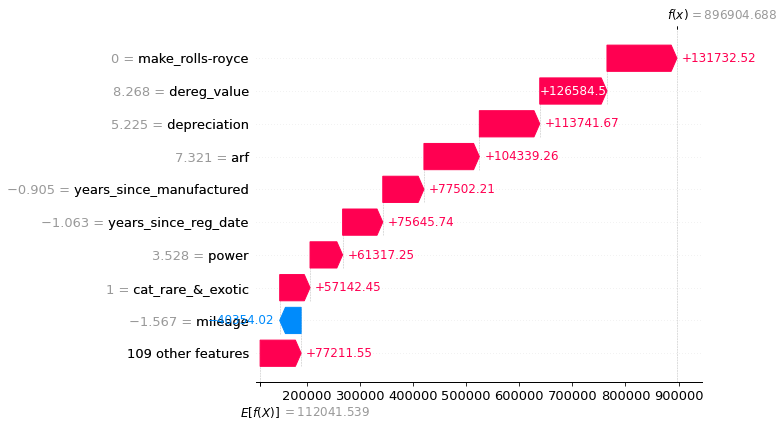

In [ ]:
shap.plots.waterfall(shap_values[0])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

**NOTE**: The above plot only shows the effect of features for the *given* record, and not the whole dataset.For the whole dataset, continue to the plots below. 

`f(x)` shows the final predicted value for the given record i.e the price for the given car will be ~SGD 897k. 

For our model, we observe that:

- Given the current car is a `rolls-royce`, we can expect to get about SGD ~132K more for the car. This is intuitive since rolls royce is a premium brand, and we would expect this car to have a high resale value.
- Simiarly, the given car has a high `dereg_value`, which helps increase it's final selling price by ~SGD127K. This is because the `dereg_value` is a sum of the `Certificate of Entitlement` value + Preferential Additional Registration Fee rebate.
- Notice that, for the features `years_since_reg_date` and `years_since_manufactured`, we can expect to add a significant amount to the final selling price. This is intuitive since having a newer car would expect to have a high resale value.
- Finally, we also note that the `mileage` for the given car is quite high(as shown in the left margin), which causes a reduction of ~SGD 50K. This is intuitive because premium cars are generally expected to have a low mileage, and hence they would not be the ideal choice for the everyday use customer.

We can visualize the effect of all features for a specific record as shown below:

In [ ]:
# NOTE: This is an interactive JS plot. You will need to run all the cells above this cell to visualize and interact
# with the plot.
shap.initjs()
shap.plots.force(shap_values[0])

### Force plot

We can also try to visualize the effect of all features for a sample(or all records) of the dataset. This plot is interactive, and can also help showcase the effect of the one feature on another set of features.

In [ ]:
# NOTE: This is an interactive JS plot. You will need to run all the cells above this cell to visualize and interact
# with the plot.
shap.initjs()
shap.plots.force(shap_values.sample(100, random_state=42))

Clicking on the interactive plot above shows the record for which the given feature effects are shown. 

### Beeswarm plot

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. 

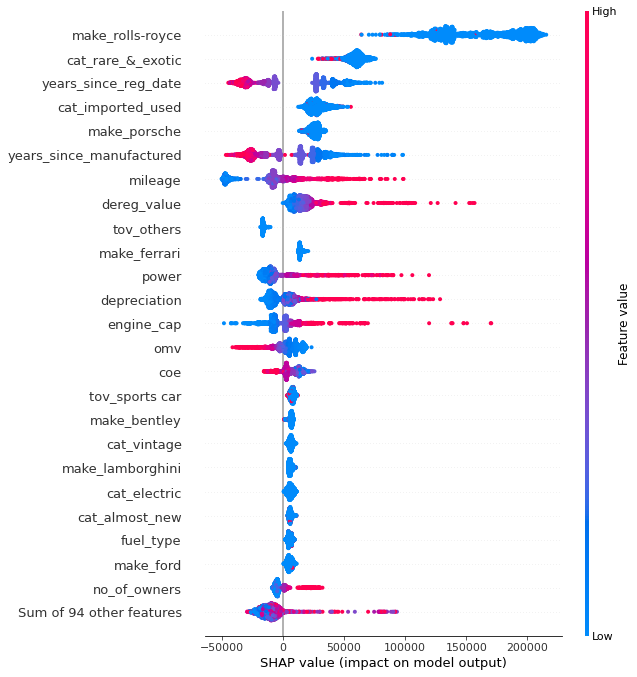

In [ ]:
shap.plots.beeswarm(shap_values, max_display=25)

The color represents the feature value (red high, blue low). Again, note that the values for each of the columns are normalized. This reveals for example that 

- Having a `Rolls Royce` car increases the resale price of the car significantly. The same applies for cars that are in the `rare and exotic` category.
- Cars that are old i.e have a high value for the columns `years_since_reg_date` and `years_since_manufactured` are expected to have a lower price. This in intuitive since customers would prefer new cars which tend to be less worn out.
- Similarly, cars with a high `dereg_value` are expected to have a high resale price.
- Cars such as `sports cars`, `electric`, `bentley`,etc. don't have a significant impact on the final price **individually**. Owners of these kind of cars would need to provide additional incentive to the customer, most likely in the form of additional accessories to increase their final price.

### Dominating Features

We know the the feature `make_rolls-royce` and `years_since_manufacted` are some of the most dominating features for the given model. Here we can also assess the individual impact of these features.

The below images plot the value of the feature against the SHAP value of the feature. Since the SHAP value represents the responsibility for a change in the model output, the plot below represents the change in predicted car price.

Vertical dispersion at a single value of `make_rolls-royce` represents interaction effects with other features. To help reveal these interactions we can color by another feature. If we pass the whole explanation tensor to the color argument the scatter plot will pick the best feature to color by. 

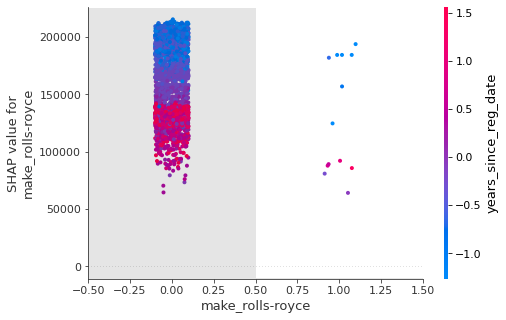

In [ ]:
shap.plots.scatter(shap_values[:,"make_rolls-royce"], color=shap_values)

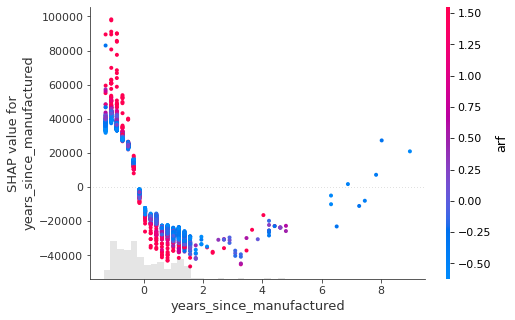

In [ ]:
shap.plots.scatter(shap_values[:,"years_since_manufactured"], color=shap_values)

From the above plots, we can see that:

- As seen above, when a car has a `make_rolls-royce` and the `years_since_reg_date` is low i.e the car is faily new, on average, the price of the car goes high. As the number of years since registration date increase, even though the car is a rolls royce, the price can go low.
- Having a high `arf` value along with a low `years_since_manufactured` value, typically less than 2 years, can lead to a very high increase in the car price.

## Submission

Here, we provide code similar to the previous notebook to generate the submission file. 

In [ ]:
test_df = pd.read_csv(FOLDER + 'test.csv')

test_prepared = preprocessed_df.transform_dataframe(test_df)

In [ ]:
test_df = pd.read_csv(FOLDER + 'test.csv')

test_prepared = preprocessed_df.transform_dataframe(test_df)
# test_prepared.loc[:, 'model'] = model_target_encoder.transform(test_prepared.pop('model'))
# test_prepared.loc[:, 'make'] = make_target_encoder.transform(test_prepared.pop('make'))
test_prepared = test_prepared.drop(test_prepared.filter(regex='model_*', axis=1), axis=1)
test_prepared = imputer.transform(test_prepared)

test_pred = final_model.predict(test_prepared)

print('Test shape:', test_prepared.shape)
print("Predictions:", test_pred)

Input shape: (5000, 29)
Transformed shape: (5000, 776)
Test shape: (5000, 118)
Predictions: [149956.80981818 261652.13286243 219411.84055705 ...  60088.51660075
  73979.67637992  19334.71475503]


In [ ]:
test_pred = best_xgb_model.predict(test_prepared)

In [ ]:
test_df = pd.read_csv(FOLDER + 'test.csv')

test_prepared = preprocessed_df.transform_dataframe(test_df)
test_prepared.loc[:, 'model'] = model_target_encoder.transform(test_prepared.pop('model'))
test_prepared.loc[:, 'make'] = make_target_encoder.transform(test_prepared.pop('make'))
test_prepared = imputer.transform(test_prepared)

test_pred = final_model.predict(test_prepared)

print('Test shape:', test_prepared.shape)
print("Predictions:", test_pred)

Input shape: (5000, 29)
Transformed shape: (5000, 43)
Test shape: (5000, 43)
Predictions: [150622.85487571 263161.66234923 224420.30595028 ...  59346.56963039
  73957.8555161   18487.34578313]


In [ ]:
submission = pd.DataFrame()
submission['Predicted'] = test_pred
submission.reset_index(inplace=True)
submission = submission.rename(columns = {'index':'Id'})
submission.to_csv('xgboost_with_optuna_submission.csv', index=False)
display(submission.head(10))

,Id,Predicted
0,0,147743.640625
1,1,266362.218750
2,2,218850.828125
3,3,162651.125000
4,4,65331.320312
5,5,149743.171875
6,6,44904.214844
7,7,50047.347656
8,8,72905.593750
9,9,110654.968750
